In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [1]:
import os, shutil

In [4]:
make_dir = lambda x : os.mkdir(x) if not os.path.exists(x) else ''

In [40]:
make_dir(test_pneumoniaBacteria_dir)

''

In [51]:
# The path to the directory where the original
# dataset was uncompressed

# The directory where we will
# store our smaller dataset
base_dir = 'chest_xray'#'/Users/fchollet/Downloads/cats_and_dogs_small'

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training
train_normal_dir = os.path.join(train_dir, 'NORMAL')
#train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
train_pneumoniaVirus_dir = os.path.join(train_dir, 'pneumoniaVirus')
train_pneumoniaBacteria_dir = os.path.join(train_dir, 'pneumoniaBacteria')

# Directory with our test cat pictures
test_normal_dir = os.path.join(test_dir, 'NORMAL')
#test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')
test_pneumoniaVirus_dir = os.path.join(test_dir, 'pneumoniaVirus')
test_pneumoniaBacteria_dir = os.path.join(test_dir, 'pneumoniaBacteria')
                                        
# Directory with our validation 
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
#validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')
validation_pneumoniaVirus_dir = os.path.join(validation_dir, 'pneumoniaVirus')
validation_pneumoniaBacteria_dir = os.path.join(validation_dir, 'pneumoniaBacteria')


In [42]:
dirContentV = []
dirContentB = []

In [43]:
def move(src, dest):
    if ('pneumoniaVirus' not in dest):
        shutil.copy(src,dest)
    elif ('pneumoniaBacteria' not in dest):
        shutil.copy(src, dest)
        

In [50]:
# split pneumonia i virus and bacteria
# train
dirContentV = os.listdir(train_pneumoniaVirus_dir)
dirContentB = os.listdir(train_pneumoniaBacteria_dir)
for f in os.listdir(train_pneumonia_dir):
    if('virus' in f):
        move(os.path.join(train_pneumonia_dir,f),train_pneumoniaVirus_dir)
    elif('bacteria' in f):
        move(os.path.join(train_pneumonia_dir,f),train_pneumoniaBacteria_dir)

#test
dirContentV = os.listdir(test_pneumoniaVirus_dir)
dirContentB = os.listdir(test_pneumoniaBacteria_dir)
for f in os.listdir(test_pneumonia_dir):
    if('virus' in f):
        move(os.path.join(test_pneumonia_dir,f),test_pneumoniaVirus_dir)
    elif('bacteria' in f):
        move(os.path.join(test_pneumonia_dir,f),test_pneumoniaBacteria_dir)

#val
dirContentV = os.listdir(validation_pneumoniaVirus_dir)
dirContentB = os.listdir(validation_pneumoniaBacteria_dir)
for f in os.listdir(validation_pneumonia_dir):
    if('virus' in f):
        move(os.path.join(validation_pneumonia_dir,f),validation_pneumoniaVirus_dir)
    elif('bacteria' in f):
        move(os.path.join(validation_pneumonia_dir,f),validation_pneumoniaBacteria_dir)


As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [10]:
print('total training normal images:', len(os.listdir(train_normal_dir)))

total training normal images: 1341


In [11]:
print('total training pneumonia images:', len(os.listdir(train_pneumonia_dir)))

total training pneumonia images: 3875


In [12]:
print('total validation normal images:', len(os.listdir(validation_normal_dir)))

total validation normal images: 8


In [13]:
print('total validation pneumonia images:', len(os.listdir(validation_pneumonia_dir)))

total validation pneumonia images: 8


In [14]:
print('total test normal images:', len(os.listdir(test_normal_dir)))

total test normal images: 234


In [15]:
print('total test pneumonia images:', len(os.listdir(test_pneumonia_dir)))

total test pneumonia images: 390



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

In [105]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               160580096 
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 1539      
Total params: 160,582,531
Trainable params: 160,582,531
Non-trainable params: 0
_________________________________________________________________


For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to 
use in various situations).

In [107]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [108]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(200, 200),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(200, 200),
        batch_size=20,
        class_mode='categorical')

Found 5216 images belonging to 3 classes.
Found 21 images belonging to 3 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [109]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20, 3)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [110]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/20
100/100 [==============================] - 104s 1s/step - loss: 5.3223 - acc: 0.6617 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 2/20
100/100 [==============================] - 99s 991ms/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 3/20
100/100 [==============================] - 102s 1s/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 4/20
100/100 [==============================] - 100s 999ms/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 5/20
100/100 [==============================] - 100s 1s/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 6/20
 75/100 [=====================>........] - ETA: 24s - loss: 5.3727 - acc: 0.6667

KeyboardInterrupt: 

It is good practice to always save your models after training:

In [97]:
model.save('pneumonia-2.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

Tras entrenar con una red muy compleja se obtienen estos resultdos en los que observamos un sobre entrenamiento y una precisión bastante mala

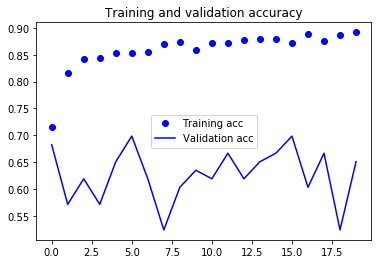

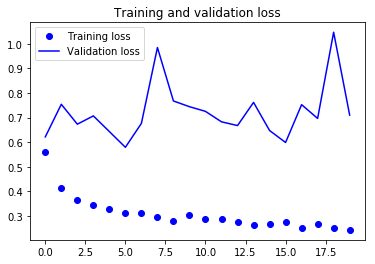

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [19]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

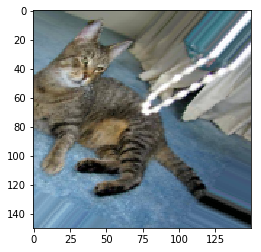

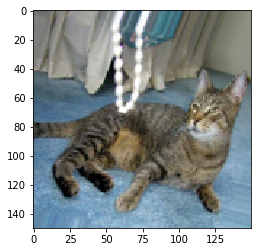

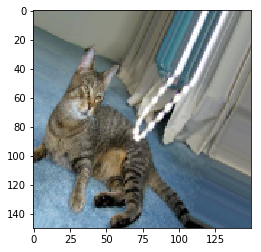

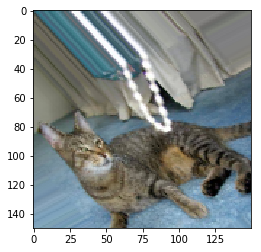

In [20]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 133s 1s/step - loss: 0.6894 - acc: 0.5338 - val_loss: 0.7048 - val_acc: 0.5121
Epoch 2/100
100/100 [==============================] - 107s 1s/step - loss: 0.6734 - acc: 0.5634 - val_loss: 0.5616 - val_acc: 0.5567
Epoch 3/100
100/100 [==============================] - 81s 815ms/step - loss: 0.6641 - acc: 0.5833 - val_loss: 0.5931 - val_acc: 0.6206
Epoch 4/100
100/100 [==============================] - 84s 845ms/step - loss: 0.6378 - acc: 0.6165 - val_loss: 0.5463 - val_acc: 0.6153
Epoch 5/100
100/100 [==============================] - 83s 833ms/step - loss: 0.6263 - acc: 0.6414 - val_loss: 0.7518 - val_acc: 0.6003
Epoch 6/100
100/100 [==============================] - 82s 817ms/step - loss: 0.6084 - acc: 0.6621 - val_loss: 0.6601 - val_acc: 0.6630
Epoch 7/100
100/100 [==============================] - 82s 818ms/step - loss: 0.5928 - acc: 0.6787 - val

Let's save our model -- we will be using it in the section on convnet visualization.

In [ ]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

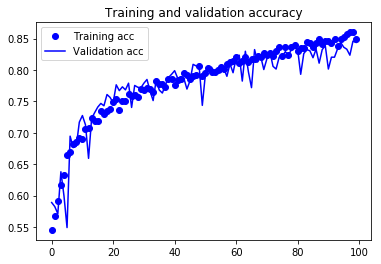

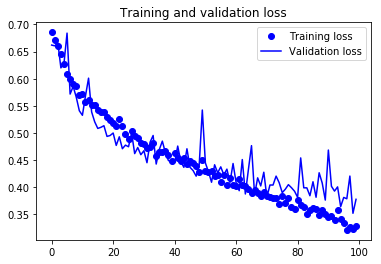

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution 
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove 
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a 
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two 
sections.